# Special topics

This notebook contains some special topics and plots requested internally at Argovis. It is a work in progress: code will transition from here to other notebooks. Public consumers should focus on our educational notebooks, starting with [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb).

In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

%cd ../
import helpers
%cd work_in_progress

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

/books
/books/work_in_progress


### Getting data from Argovis

In the following we ask Argovis to return profiles that have both temperature and salinity with QC = 1 (the best QC flag) in a region and time period of interest. If curious, try and run the notebook using 'data': 'temperature,salinity' in the following cell (instead of 'data': 'temperature,1,salinity,1'). The TS diagrams will look different as some data with bad QC will be returned, if we don't tell Argovis we only want QC = 1.

In [2]:
# get TS profiles in a region and time period of interest

pac_region = [[-155,-1.5],[-155,-30],[-145,-30],[-145,-1.5],[-155,-1.5]]
argo = {
    'startDate': '2022-12-30T00:00:00Z',
    'endDate': '2023-01-13T00:00:00Z',
    'polygon': pac_region,
    'data': 'temperature,1,salinity,1'
} # querying only profiles that have both temperature and salinity

floats = avh.query('argo', options=argo, apikey=API_KEY, apiroot=API_ROOT)

In [3]:
# let's select only levels that have a valid T and S
def delete_if_none(list1, list2, list3):
    result1 = []
    result2 = []
    result3 = []

    for i in range(len(list1)):
        if list1[i] is not None and list2[i] is not None and list3[i] is not None:
            result1.append(list1[i])
            result2.append(list2[i])
            result3.append(list3[i])

    return result1, result2, result3

def find_variable_index(profile, variable):
    return profile['data_info'][0].index(variable)


filtered_profiles = []
for f in floats:
    filtered_pressure, filtered_temperature, filtered_salinity = delete_if_none(f['data'][find_variable_index(f, 'pressure')], f['data'][find_variable_index(f, 'temperature')], f['data'][find_variable_index(f, 'salinity')])
    filtered_profiles.append([filtered_pressure, filtered_temperature, filtered_salinity])

In [4]:
# only makes sense for profiles that have levels spanning the region of interest

shallow = 10
deep = 1800

# select only profiles that have measurements in the range of interest
profiles = [f for f in filtered_profiles if f[0][0] < shallow and f[0][-1] > deep]

In [5]:
# interpolate temperature and salinity

levels = list(range(shallow,deep,5))

interpolated_temperatures = np.array([list(scipy.interpolate.pchip_interpolate(p[0], p[1], levels)) for p in profiles])
interpolated_salinity = np.array([list(scipy.interpolate.pchip_interpolate(p[0], p[2], levels)) for p in profiles])

In [6]:
# transpose and cast to various rectangular forms as desired

numpy.shape(interpolated_temperatures)

(35, 358)

### TS plot using scatter

Text(0.5, 0, 'Salinity, psu')

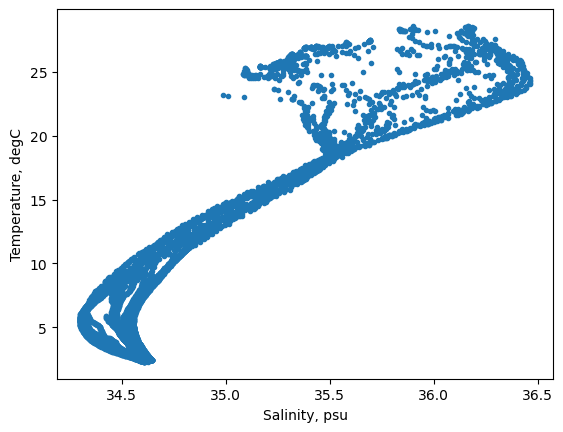

In [7]:
plt.plot(interpolated_salinity.flatten(),interpolated_temperatures.flatten(),marker='.',linestyle='')
plt.ylabel('Temperature, degC')
plt.xlabel('Salinity, psu')


### Joint PDF 

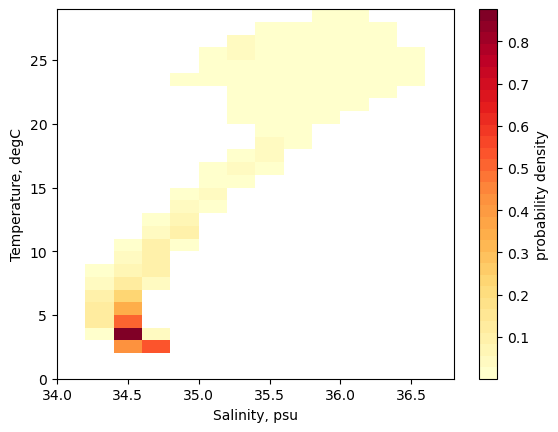

In [8]:
plt.hist2d(interpolated_salinity.flatten(),interpolated_temperatures.flatten(),density=True,
           bins=[np.arange(34,37,.2),np.arange(0,30,1)],
           cmin=1.e-100,cmap=cm.get_cmap('YlOrRd', 32))#'YlOrRd') #hot_r
plt.ylabel('Temperature, degC')
plt.xlabel('Salinity, psu')
cbar = plt.colorbar()
cbar.set_label('probability density')

## Average profile in a region

In [9]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import dateutil

%cd ../
from Exploring_Argo_BGC_with_Argovis_helpers import interpolate
import helpers
%cd work_in_progress

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

/books
/books/work_in_progress


In [10]:
# get doxy profiles in a region and time period of interest

variable             = 'doxy' # variable name in Argo profiles
variable_gridded     = 'oxygen' # variable name in glodap gridded product
product_gridded      = 'glodap'
variable_title       = 'Oxygen, umol/kg'

interp_levels        = list(range(10,2001))[0::20]

box_regions_list     = [
                        [[-48,45],[-38,50]],
                        ]
    
# box_regions_list     = [
#                         [[-78,45],[-10,50]],
#                         [[-180,45],[-127,50]],
#                         ]

Tue Mar 26 16:50:56 UTC 2024
Tue Mar 26 16:51:12 UTC 2024


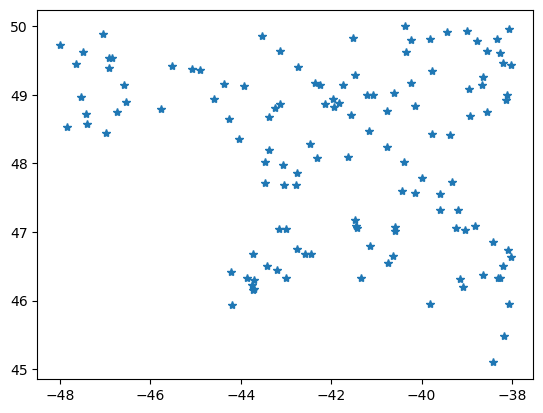

In [11]:
!date

regions_list_data                 = []
regions_list_data_noave           = []
regions_list_data_levels          = []
regions_list_data_noave_nointerp  = []
regions_list_data_grid_axarray    = []
###### profiles
for ireg in box_regions_list:
    # get profiles in region
    argo = {
            'startDate': '2022-01-01T00:00:00Z',
            'endDate': '2022-12-31T00:00:00Z',
            'box': ireg,
            'data': variable+',1'
            } # querying only profiles that have good qc doxy 
            # 'polygon': ireg,

    profiles = avh.query('argo', options=argo, apikey=API_KEY, apiroot=API_ROOT) 
    # interpolate profiles   
    interpolated_profiles      = []
    interpolated_profiles_time = []
    interpolated_profiles_lon  = []
    interpolated_profiles_lat  = []
    
    for i in list(range(0,len(profiles)-1)):
        if len(profiles[i]['data'][0]) > 1:
            interpolated_profiles.append(interpolate(profiles[i],interp_levels))
            interpolated_profiles_time.append(dateutil.parser.isoparse(profiles[i]['timestamp'])) 
            interpolated_profiles_lon.append(profiles[i]['geolocation']['coordinates'][0])
            interpolated_profiles_lat.append(profiles[i]['geolocation']['coordinates'][1])
    # shape variable into something appropriate
    data = [x['data'] for x in interpolated_profiles]
    data = [[level[variable] for level in x] for x in data]
    # store profile data
    regions_list_data_noave.append(data)
    regions_list_data_noave_nointerp.append([x['data'] for x in profiles])
    data = np.transpose(data)
    regions_list_data.append(np.nanmean(data,1))
    regions_list_data_levels.append(interp_levels)
    
    plt.figure()
    plt.plot(interpolated_profiles_lon,interpolated_profiles_lat,marker='*',linestyle='none')
    
!date    

In [12]:
data

array([[236.13448778, 233.34111144, 243.64491572, ..., 234.84129752,
        281.88373688, 259.10115519],
       [233.28597876, 233.25228855, 236.017441  , ..., 234.7603689 ,
        282.0377913 , 259.6055719 ],
       [224.67953382, 233.18446462, 213.24377085, ..., 234.76175517,
        281.9355743 , 260.48484869],
       ...,
       [270.71940177, 273.52785167, 264.11687675, ..., 276.63532964,
        281.29380932, 285.33877001],
       [269.69441718, 272.93834794, 263.715546  , ..., 275.99690358,
        280.79914945, 284.77063505],
       [269.45481107,          nan, 263.10502959, ...,          nan,
        280.42547976, 284.11869586]])

In [13]:
!date
####### gridded data
for ireg in box_regions_list:
    grids_opt = {
            'box': ireg,
            'data': variable_gridded
            } # querying only profiles that have good qc doxy

    grids = avh.query('grids/'+product_gridded, options=grids_opt, apikey=API_KEY, apiroot=API_ROOT)
    grids_opt  = {
                    "id": grids[0]['metadata'][0]
                    }
    grids_meta = avh.query('grids/meta', options=grids_opt, apikey=API_KEY, apiroot=API_ROOT)
    
    xar = helpers.grids_to_xarray(grids,grids_meta)
    
    regions_list_data_grid_axarray.append(xar)
    regions_list_data.append(helpers.regional_mean(xar)['data'].values.flatten())
    regions_list_data_levels.append(grids_meta[0]['levels'])
    if len(helpers.regional_mean(xar)['data'].values.flatten())!=len(grids_meta[0]['levels']):
        stop_check_len
        
!date        


Tue Mar 26 16:51:15 UTC 2024
Tue Mar 26 16:51:16 UTC 2024


In [14]:
# approximate factor: 32*1.025/1000 (to go from umol/kg to mg/l)
# see example for Pacific vs Atlantic (Fig. 5.6.3) at https://rwu.pressbooks.pub/webboceanography/chapter/5-6-nitrogen-and-nutrients/


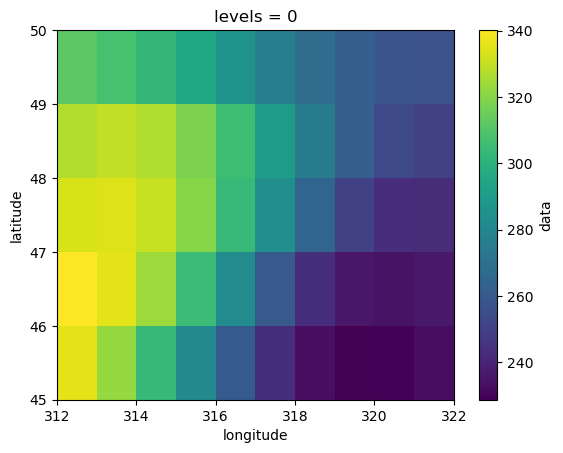

In [15]:
for iaxr in regions_list_data_grid_axarray:
    plt.figure()
    iaxr['data'][:,:,0].plot()

In [16]:
cols = ['k','r','b','m']

Text(0.5, 0, 'variable_title')

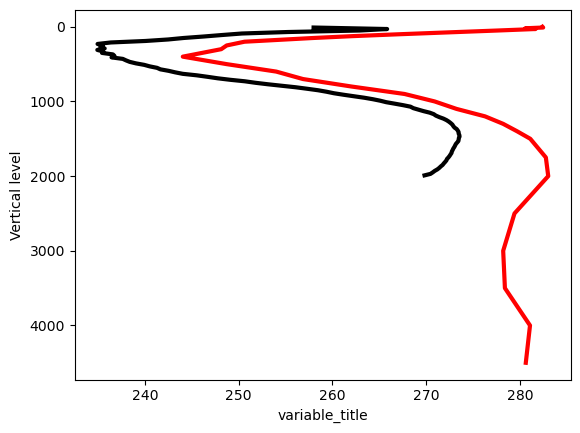

In [17]:
for i,idata in enumerate(regions_list_data):
    plt.plot(idata,regions_list_data_levels[i],color=cols[i],linewidth=3)
plt.gca().invert_yaxis()
plt.ylabel('Vertical level')
plt.xlabel('variable_title')

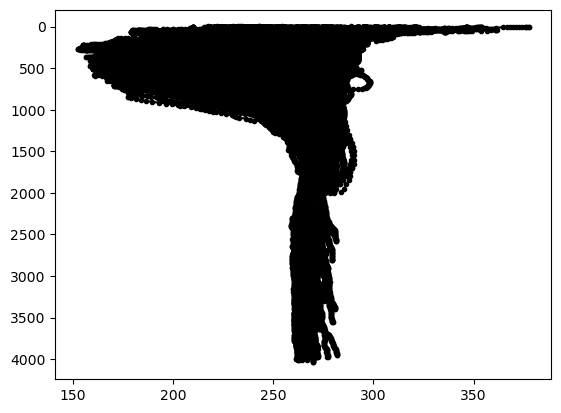

In [18]:
# plot raw profiles that go into the average
for i,idata in enumerate(regions_list_data_noave_nointerp):
    for iidata in idata:
        
        plt.plot(iidata[0],iidata[1],color=cols[i],marker='.')
        if sum(np.array(iidata[0])<0) != 0:
            ciao
plt.gca().invert_yaxis()        
        

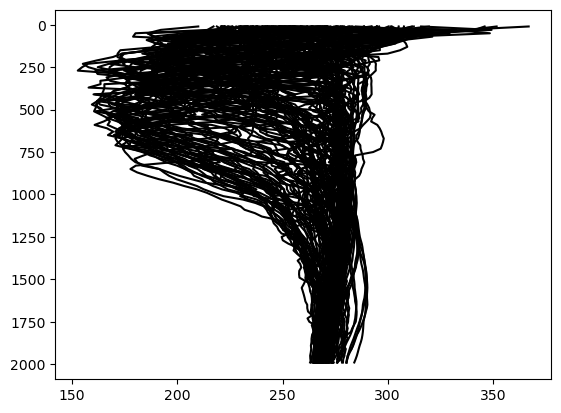

In [19]:
for i,idata in enumerate(regions_list_data_noave):
    for ii,iidata in enumerate(idata):
        
        plt.plot(iidata,regions_list_data_levels[i],color=cols[i])
        if sum(np.array(iidata)<0) != 0:
            ciao
plt.gca().invert_yaxis()